In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import random
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import save_load
import train_nn
from fetch_db import reddit_data
from pre_nn import text_field, device, destination_folder, df_data, df_train, df_test, df_valid

/Users/Hilal/opt/anaconda3/envs/chatbot/lib/python3.6/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [2]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [3]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_nn.train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [13/260], Train Loss: -4.9346, Valid Loss: -17.1667
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [1/10], Step [26/260], Train Loss: -28.7581, Valid Loss: -46.7353
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [2/10], Step [39/260], Train Loss: -55.1303, Valid Loss: -68.1509
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [2/10], Step [52/260], Train Loss: -300.4585, Valid Loss: -447.8365
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [3/10], Step [65/260], Train Loss: -411.6029, Valid Loss: -447.8365
Epoch [3/10], Step [78/260], Train Loss: -477.8846, Valid Loss: -447.8365
Epoch [4/10], Step [91/260], Train Loss: -419.8927, Valid Loss: -447.8365
Epoch [4/10], Step [104/260], Train Loss: -476.0661, Valid Loss: -447.8365
Epoch [5/10], Step [117/260], Train Loss: -422.1154, Valid Loss: -447.8365
Epoch [5/10], Step [130/260], Train Loss: -477.8846, Valid Loss: -4

Model loaded from <== Data/metrics.pt


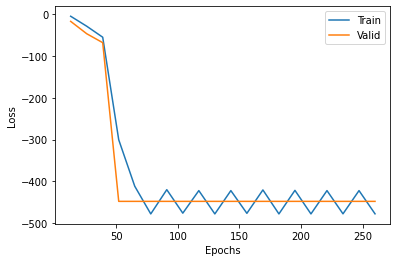

In [4]:
train_loss_list, valid_loss_list, global_steps_list = save_load.load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
print(len(df_data))
print(len(df_train))
print(len(df_valid))
print(len(df_test))

992
802
90
100
